In [1]:
import tifffile
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyvista as pv
import cv2 as cv
import numpy as np
import itertools
import scipy
import time
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import mark_boundaries
from scipy.ndimage import generic_filter
from cv2 import fastNlMeansDenoising,fastNlMeansDenoisingMulti, medianBlur

In [2]:
files = ['B51_bag02.tif' , 'B51_bag40.tif' , 'B51_bag80.tif' , 'B51_bag120.tif']
input_path = ''
file_number = 3
img = tifffile.imread(input_path+files [file_number])
print (img.shape)


(8721, 1008, 1008)


In [3]:
def denoising (vol):
    new_vol = np.zeros_like(vol)
    for i in range (vol.shape[0]):
        new_vol [i] = fastNlMeansDenoising(vol[i],h = 10, templateWindowSize = 3, searchWindowSize = 100)
    return new_vol


In [4]:
def filter_region_of_interest(vol,epsilon = 100,threshold = 10):
    mask = np.zeros_like(vol)
    for i in range (vol.shape[0]):
        
        #Threshholding 
        ret,thresh = cv.threshold(vol[i], threshold, 1, cv.THRESH_BINARY)

        # Finding contours for the thresholded image
        contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        # Concatenate all contours into a single array
        all_points = np.concatenate(contours)
        #contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
        convexHull = cv.convexHull(all_points)
        
        cv.drawContours(mask[i], [convexHull], -1, 254, -1 )
        
        # Finding contours out of the convex hull
        contours, hierarchy = cv.findContours(mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

        contour = contours[0] #biggest outside contour

        #Step_2 removing the Casing
        polygon = Polygon(contour[:, 0, :])

        # Compute offset
        offset_polygon = polygon.buffer(-epsilon)

        # Convert offset polygon to numpy array and draw on image
        points = np.array(offset_polygon.exterior.coords)
        points = np.expand_dims(points.astype(np.int32), axis=1)
        
        mask[i] = np.zeros_like(mask[i])
        cv.drawContours(mask[i], [points], -1, 254, -1 )
    
    return mask
    


In [5]:
def get_neighbours (vol):
        #creating a foot print of the desired neighbors
    # currently a cross shape
    footprint = np.array([[[0,0,0],
                          [0,1,0],
                          [0,0,0]],
                        [[0,1,0],
                          [1,1,1],
                          [0,1,0]],
                        [[0,0,0],
                          [0,1,0],
                          [0,0,0]]])

    i = 0
    list_pixels = np.zeros(((vol.shape[0]-2)*(vol.shape[1]-2)*(vol.shape[2]-2),footprint.sum()))
    def test_func(values):
        nonlocal list_pixels
        nonlocal i
        #print(values)
        #print (type(values))
        if not np.any(values == -10):
            list_pixels[i] = values
            i += 1

        return values.sum()


    neighbor_array = generic_filter(vol,test_func,footprint=footprint, cval= -10, mode='constant' )

    list_pixels = list_pixels.reshape(((vol.shape[0]-2),(vol.shape[1]-2),(vol.shape[2]-2),footprint.sum()))
    
    return list_pixels

'''    from skimage.util import view_as_windows
    
    #get window properties of single pixel 27 features
    original_shape = vol.shape

    neighborhoods = view_as_windows(vol, window_box)
'''
    

'    from skimage.util import view_as_windows\n    \n    #get window properties of single pixel 27 features\n    original_shape = vol.shape\n\n    neighborhoods = view_as_windows(vol, window_box)\n'

In [6]:
def get_training_features(vol,neighborhoods, window_box = 3*3*3):
    
    ice_area = filter_region_of_interest(vol)
    
    training_n_elements = len(ice_area[ice_area > 0])
    #trainig_features = np.zeros((training_n_elements, window_box))
    
    # resizing the ice area to the size that the neighbours are available (dropping one leayer each dimenssion)
    if window_box == 3*3*3:
        ice_area = ice_area [1:ice_area.shape[0]-1, 1:ice_area.shape[1]-1, 1:ice_area.shape[2]-1 ]
    else:
        print ('croping part needs to be modified')
    
    trainig_features = neighborhoods [ice_area > 0]
    #print (trainig_features.shape, ' available features for training')
    #trainig_features = trainig_features.reshape((trainig_features.shape[0], -1))
    #print (trainig_features.shape, ' after')            
    return trainig_features

In [7]:
def train_GMM (trainig_features):
    
    trainig_features = trainig_features.astype('float32')
    trainig_features = cv.normalize(trainig_features, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    
    gmm_model = GMM(n_components=2, random_state=20, covariance_type='tied', init_params='kmeans').fit(trainig_features)
    ice_class = gmm_model.means_.round(3).tolist()
    ice_class_index = ice_class.index(max(ice_class))
    
    return gmm_model, ice_class_index


In [8]:
def predict_with_GMM (gmm_model, ice_class_index, neighborhoods):
    
    neighborhoods = neighborhoods.astype('float32')
    neighborhoods = cv.normalize(neighborhoods, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    #shape>> (n,n,n,3,3,3)
    
    segmented = np.zeros((neighborhoods.shape[0],neighborhoods.shape[1],neighborhoods.shape[2]))
    
    reshaped_ne = neighborhoods.reshape(neighborhoods.shape[0],neighborhoods.shape[1],neighborhoods.shape[2] , -1)
    #shape>> (n,n,n,27)
    
    reshaped_ne = reshaped_ne.reshape(reshaped_ne.shape[0]*reshaped_ne.shape[1]*reshaped_ne.shape[2],reshaped_ne.shape[3])
    #shape>> (n,27)
    
    
    predictions = gmm_model.predict(reshaped_ne)
    predictions = predictions.reshape((neighborhoods.shape[0], neighborhoods.shape[1], neighborhoods.shape[2]))

    segmented[predictions == ice_class_index] = 100
    segmented[predictions != ice_class_index] = 0
    segmented = segmented.astype('uint8')
    
    return segmented
    
    

In [ ]:
t1 = time.time()
batch = 100

#starting layer should be more than 1
starting_layer = 750
ending_layer = 8267
#starting_layer = 1000
#ending_layer = 1021

n_layers = ending_layer - starting_layer
cycle = n_layers//batch

# creating a numpy array to concatinate the reuslts into it
segmented = np.zeros((1,img.shape[1]-2,img.shape[2]-2), dtype = 'uint8')

for i in range (cycle):
    print(round(i*100//cycle), end='\r')
    
    if i == cycle-1: # the last batch will take some extra images
        vol = img[starting_layer+(i*batch)-1:ending_layer]
    else:
        vol = img[starting_layer+(i*batch)-1 : starting_layer+((i+1)*batch)+1 ]

    vol = denoising(vol)
    neighbours = get_neighbours(vol) #shape>> (n, 3*3*3)
    trainig_features = get_training_features(vol, neighbours) #shape>> (n, 3*3*3) pixels only in region of interest
    gmm_model, ice_class_index = train_GMM (trainig_features)
    prediction = predict_with_GMM(gmm_model, ice_class_index, neighbours) #shape>> (n, 1008, 1008)
    segmented = np.concatenate((segmented, prediction),0)
    
t2 = time.time()
print (round(t2-t1))

In [ ]:
tifffile.imwrite(input_path+ '//GMM_3D//' +'_corss'+ files [file_number], segmented)
tifffile.imwrite(input_path+ '//GMM_3D//' + '_corresponding_img'+'_cross' + files [file_number], img[starting_layer:ending_layer, 1:-1, 1:-1])

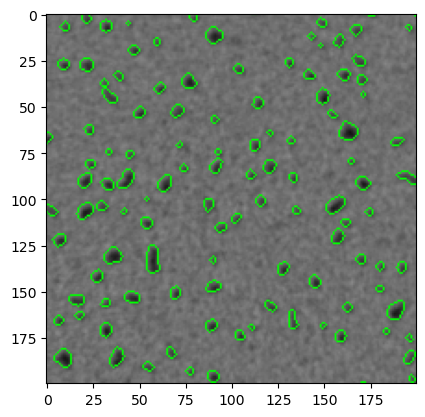

In [193]:
num = 2
cnts, hierarchy = cv.findContours(segmented[num], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
torgb = cv.cvtColor(img[starting_layer + num-1],cv.COLOR_GRAY2RGB)
cv.drawContours(torgb, cnts, -1, (0,255,0), 1)
plt.imshow(torgb[400:600 ,400:600])
#plt.imshow(torgb)